In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import dlib
import pickle
import h5py
import cv2
import scipy

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
%tensorflow_version 2.x
import tensorflow as tf

Getting FER2013 dataset

In [0]:
dataset = pd.read_csv('/content/drive/My Drive/Datasets/fer2013.csv')

In [0]:
dataset.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [0]:
def get_images(usage):
  df = dataset[dataset['Usage'] == usage]
  y = tf.keras.utils.to_categorical(df['emotion'])
  X = np.array([values.split() for values in df['pixels']])
  X = X.astype(np.float).reshape(len(df), 48, 48, 1)
  return (X, y)

In [0]:
X_train, y_train = get_images('Training')
X_test, y_test =  get_images('PublicTest')
X_validate, y_validate = get_images('PrivateTest')

In [0]:
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)

print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

print('X_validate:', X_validate.shape)
print('y_validate:', y_validate.shape)

X_train: (28709, 48, 48, 1)
y_train: (28709, 7)
X_test: (3589, 48, 48, 1)
y_test: (3589, 7)
X_validate: (3589, 48, 48, 1)
y_validate: (3589, 7)


In [0]:
def get_label(arg):
  labels = {0:'Angry',1:'Disgust',2:'Fear',3:'Happy',4:'Sad',5:'Surprise',6:'Neutral'}
  return (labels.get(arg,"Invalid Emotion"))

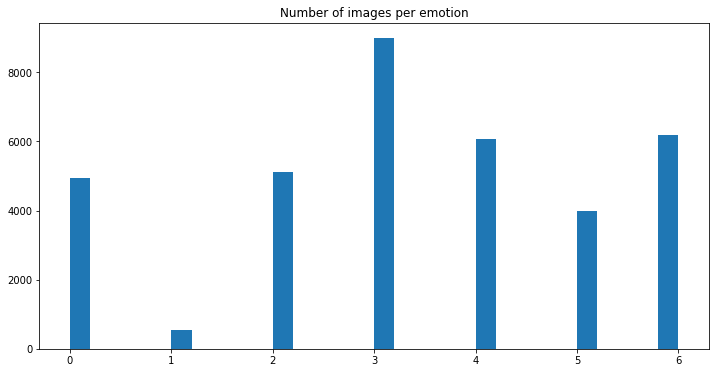

In [0]:
plt.figure(figsize=(12,6))
plt.hist(dataset['emotion'], bins=30)
plt.title("Number of images per emotion")
plt.show()

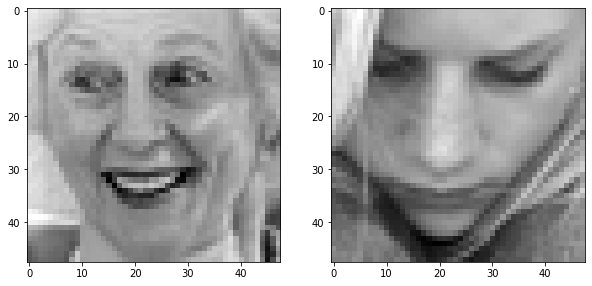

In [0]:
plt.figure(figsize=[10,5])

# Display the first image in training data
plt.subplot(121)
plt.imshow(np.squeeze(X_train[25,:,:], axis = 2), cmap='gray')

# Display the first image in testing data
plt.subplot(122)
plt.imshow(np.squeeze(X_test[26,:,:], axis = 2), cmap='gray')

In [0]:
train_data = X_train.astype('float32')
test_data = X_test.astype('float32')
val_data = X_validate.astype('float32')

train_data /= 255
test_data /= 255
val_data /= 255

In [0]:
def detect_face(frame):
  #Cascade classifier pretrained model
  cascPath = '/content/drive/My Drive/BE Project/sarvesh/haarcascades/haarcascade_frontalface_default.xml'
  faceCascade = cv2.CascadeClassifier(cascPath)
  #BGR to gray conversion
  gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
  #Cascade multiscale classifier
  detected_faces = faceCascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=6,
                                                minSize=(48,48),
                                                flags=cv2.CASCADE_SCALE_IMAGE)
  coord=[]
  for x, y, w, h in detected_faces:
    if w>100:
      sub_img=frame[y:y+h,x:x+w]
      coord.append([x,y,w,h])
  return gray, detected_faces, coord

In [0]:
def extract_face_features(faces, offset_coeffs=(0.075,0.05)):
  gray=faces[0]
  detected_face=faces[1]
  new_face=[]
  for det in detected_face:
    x,y,w,h=det
    #offset-coeff, np.floor takes lowest int (delete border of image)
    hor_offset=np.int(np.floor(offset_coeffs[0]*w))
    ver_offset=np.int(np.floor(offset_coeffs[1]*h))
    extracted_face=gray[y+ver_offset:y+h, x+hor_offset:x-hor_offset+w]
    #zoom
    new_extracted_face=scipy.ndimage.zoom(extracted_face,(48/extracted_face.shape[0],48/extracted_face.shape[1]))
    new_extracted_face=new_extracted_face.astype(np.float32)
    #scale
    new_extracted_face/=float(new_extracted_face.max())
    new_face.append(new_extracted_face)
  return new_face

In [0]:
from google.colab.patches import cv2_imshow

Sample Image

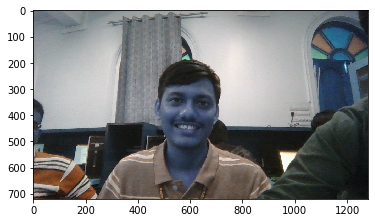

In [0]:
sample_image = '/content/drive/My Drive/Datasets/test_images/happy3.jpg'
sample_face = cv2.imread(sample_image, cv2.COLOR_BGR2RGB)
plt.imshow(sample_face)

Extracted Face

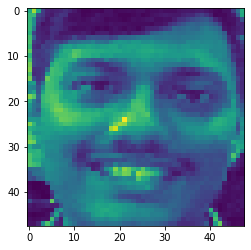

In [0]:
face = extract_face_features(detect_face(sample_face))[0]
plt.imshow(face)

In [0]:
face.shape

(48, 48)

Model

In [0]:
def createModel():
  model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3,3),padding="same", activation='relu', input_shape=(48, 48, 1),  data_format='channels_last',kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = (2,2)),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
   
    tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = (2,2)),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
   
    tf.keras.layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = (2,2)),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
   
    tf.keras.layers.Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = (2,2)),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(7, activation = 'softmax')
    ])
  return model

In [0]:
model_fervideo_1 = createModel()
model_fervideo_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       5

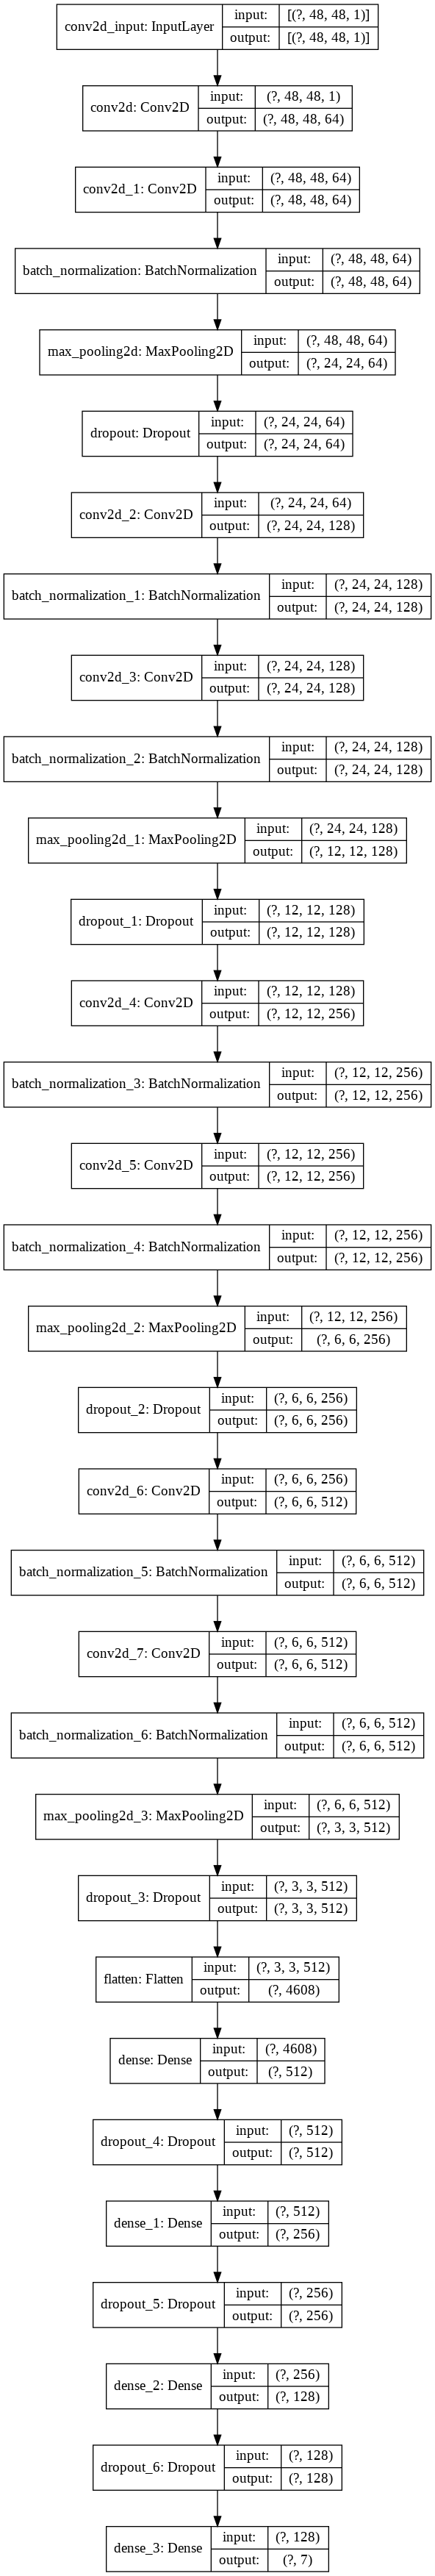

In [0]:
tf.keras.utils.plot_model(model_fervideo_1, to_file='/content/drive/My Drive/BE PROJECT TRAINED MODELS/fer model video/model_fervideo_1.png', show_shapes=True, show_layer_names=True)

Training the model

In [0]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    zoom_range=0.2,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False
)

In [0]:
model_fervideo_1.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
lr_reducer_v = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, verbose=1)

tensorboard_v = tf.keras.callbacks.TensorBoard(log_dir='./logs')

early_stopper_v = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1, mode='auto')

checkpointer_v = tf.keras.callbacks.ModelCheckpoint('model_fervideo_1.h5', monitor='val_loss', verbose=1, save_best_only=True)

In [0]:
batch_size=256
epochs=100
history_fer_video_1 = model_fervideo_1.fit(
    datagen.flow(train_data, y_train, batch_size=batch_size),
    #train_data, y_train,

    #batch_size=batch_size,
    steps_per_epoch=int(np.ceil(train_data.shape[0] / float(batch_size))),
    epochs = epochs,
    verbose=1,
    shuffle=True,
    validation_data=(val_data, y_validate),
    callbacks=[lr_reducer_v, tensorboard_v, early_stopper_v, checkpointer_v]
)

  ...
    to  
  ['...']
Train for 113 steps, validate on 3589 samples
Epoch 1/100
112/113 [============================>.] - ETA: 0s - loss: 2.0631 - accuracy: 0.2102
Epoch 00001: val_loss improved from inf to 1.85012, saving model to model_fervideo_1.h5
113/113 [==============================] - 23s 202ms/step - loss: 2.0613 - accuracy: 0.2104 - val_loss: 1.8501 - val_accuracy: 0.2449
Epoch 2/100
112/113 [============================>.] - ETA: 0s - loss: 1.8523 - accuracy: 0.2329
Epoch 00002: val_loss improved from 1.85012 to 1.82900, saving model to model_fervideo_1.h5
113/113 [==============================] - 14s 122ms/step - loss: 1.8521 - accuracy: 0.2326 - val_loss: 1.8290 - val_accuracy: 0.2449
Epoch 3/100
112/113 [============================>.] - ETA: 0s - loss: 1.8328 - accuracy: 0.2414
Epoch 00003: val_loss did not improve from 1.82900
113/113 [==============================] - 13s 118ms/step - loss: 1.8329 - accuracy: 0.2417 - val_loss: 1.8351 - val_accuracy: 0.2449
Epoch

Text(0.5, 1.0, 'Accuracy Curves')

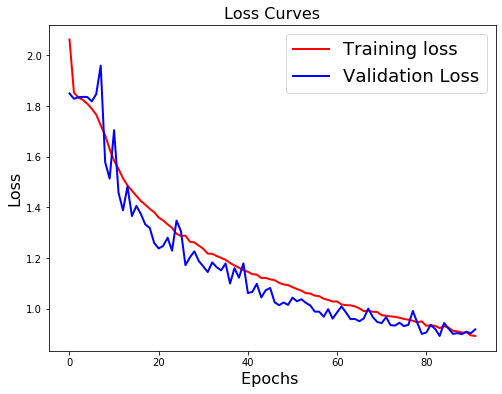

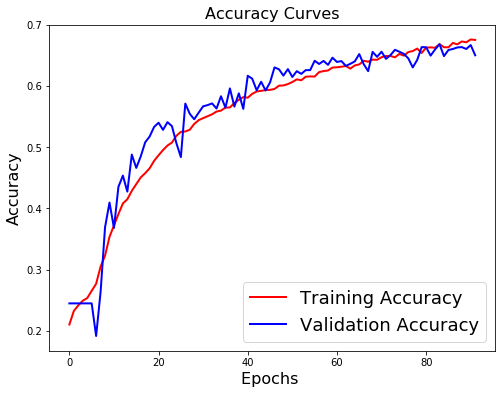

In [0]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history_fer_video_1.history['loss'],'r',linewidth=2.0)
plt.plot(history_fer_video_1.history['val_loss'],'b',linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history_fer_video_1.history['accuracy'],'r',linewidth=2.0)
plt.plot(history_fer_video_1.history['val_accuracy'],'b',linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [0]:
model_fervideo_1.save('model_fervideo_1.h5')

Visualize layers and outputs

In [0]:
layer_outputs = [layer.output for layer in model_fervideo_1.layers[:22]]
#extract outputs of top 22 layers
activation_model = tf.keras.models.Model(inputs=model_fervideo_1.input, outputs=layer_outputs)

In [0]:
layer_names = []
for layer in model_fervideo_1.layers[:22]:
  layer_names.append(layer.name)


In [0]:
to_predict=np.reshape(face.flatten(), (1,48,48,1))
res=model_fervideo_1.predict(to_predict)
activations = activation_model.predict(to_predict)

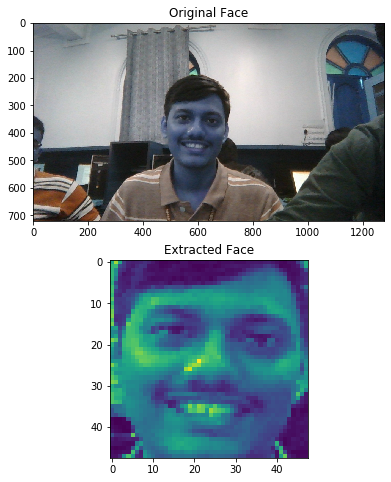

In [0]:
plt.figure(figsize=(12,8))

plt.subplot(211)
plt.title("Original Face")
plt.imshow(sample_face)

plt.subplot(212)
plt.title("Extracted Face")
plt.imshow(face)

plt.show()

In [0]:
images_per_row=64

In [0]:
for layer_name,layer_activation in zip(layer_names, activations): # Displays the feature maps
  n_features = layer_activation.shape[-1] # Number of features in the feature map
  size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
  n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
  display_grid = np.zeros((size * n_cols, images_per_row * size))
  for col in range(n_cols): # Tiles each filter into a big horizontal grid
    for row in range(images_per_row):
            channel_image = layer_activation[0,:, :,col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

Output hidden; open in https://colab.research.google.com to view.

In [0]:
result_num = np.argmax(res)
print(result_num)

3


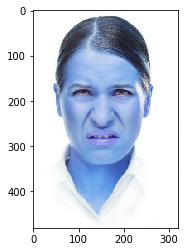

In [0]:
image = '/content/drive/My Drive/Datasets/test_images/person_d.jpg'
sample_face = cv2.imread(image, cv2.COLOR_BGR2RGB)
plt.imshow(sample_face)

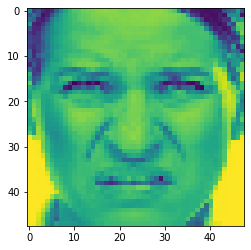

In [0]:
face1 = extract_face_features(detect_face(sample_face))[0]
plt.imshow(face1)

In [0]:
pred = np.reshape(face1.flatten(), (1,48,48,1))
res=model_fervideo_1.predict(pred)
result_num = np.argmax(res)
print(result_num)
print(get_label(result_num))

1
Disgust
